In [2]:
#import packages
import os
import pandas as pd
import numpy as np

df = pd.read_excel('scoring_2.xlsx', sheet_name='Лист2') #Read excel file
df = df.dropna()
df = df.drop(columns = ['birth_date','date_beggining', 'date_end'])

https://github.com/Sundar0989/Variable-Selection-Using-Python/blob/master/Variable%20Selection%20using%20Python%20-%20Vote%20based%20approach.ipynb

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16346 entries, 0 to 16378
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   SEX           16346 non-null  object
 1   day_birth     16346 non-null  object
 2   month_birth   16346 non-null  object
 3   age           16346 non-null  int64 
 4   experience    16346 non-null  int64 
 5   month_happen  16346 non-null  object
 6   day_happen    16346 non-null  object
 7   car_age       16346 non-null  int64 
 8   loss          16346 non-null  int64 
 9   safe          16346 non-null  int64 
 10  premium       16346 non-null  int64 
 11  model         16346 non-null  object
 12  y             16346 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.7+ MB


In [4]:
df.head()

,SEX,day_birth,month_birth,age,experience,month_happen,day_happen,car_age,loss,safe,premium,model,y
0,М,четверг,Сентябрь,49,25,Октябрь,вторник,1.0,2945.00,400000,4712.4,Honda CIVIC,1
1,М,вторник,Июнь,37,23,Октябрь,суббота,8.0,2380.00,400000,2772.0,ВАЗ 21110,1
2,М,вторник,Июнь,37,23,Октябрь,суббота,8.0,67509.01,400000,2772.0,ВАЗ 21110,0
3,М,понедельник,Март,57,39,Ноябрь,вторник,3.0,120000.00,400000,3880.8,Chery Tiggo(T11),0
4,М,пятница,Сентябрь,43,21,Сентябрь,четверг,12.0,348.00,400000,4435.2,Mercedes-Benz E240,1


In [ ]:
df['loss'] = df['loss'].fillna(0)

In [5]:
df['car_age'] = df['car_age'].astype(np.int64)
df['loss'] = df['loss'].astype(np.int64)
df['premium'] = df['premium'].astype(np.int64)


In [7]:
# Data transformation
# Convert categorical values to numeric using label encoder
from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
# Encoding the categorical variable
fit = df.select_dtypes(include=['object']).apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    df[i] = d[i].transform(df[i])

In [8]:
features = df[df.columns.difference(['y'])]
labels = df['y']

3. Variable Selection
3,1 Weight of Evidence and Information Value

In [9]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [10]:
final_iv, IV = data_vars(df,df.y)

In [11]:
IV = IV.rename(columns={'VAR_NAME':'index'})

In [12]:
IV.sort_values(['IV'],ascending=0)

,index,IV
6,loss,0.615099
10,premium,0.005863
3,day_birth,0.000599
0,SEX,0.000575
2,car_age,0.000284
9,month_happen,0.000145
8,month_birth,0.000116
4,day_happen,0.000073
5,experience,0.000049
7,model,0.000011


In [13]:
df.describe()

,SEX,day_birth,month_birth,age,experience,month_happen,day_happen,car_age,loss,safe,premium,model,y
count,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000
mean,0.843264,2.990946,5.643583,42.661263,24.257249,5.656674,3.137954,4.891594,25785.563196,399706.350177,4192.266365,1058.833598,0.799095
std,0.363562,1.996152,3.532946,9.733171,7.392742,3.434545,1.940818,16.417991,28637.238124,7810.036138,1607.212653,566.263278,0.400690
min,0.000000,0.000000,0.000000,-39.000000,-71.000000,0.000000,0.000000,-2.000000,0.000000,160000.000000,273.000000,0.000000,0.000000
25%,1.000000,1.000000,3.000000,34.000000,18.000000,3.000000,1.000000,1.000000,7121.250000,400000.000000,3063.000000,509.000000,1.000000
50%,1.000000,3.000000,6.000000,41.000000,22.000000,6.000000,3.000000,3.000000,15593.000000,400000.000000,4039.000000,1165.000000,1.000000
75%,1.000000,5.000000,9.000000,50.000000,28.000000,9.000000,5.000000,7.000000,32732.250000,400000.000000,5149.000000,1515.000000,1.000000
max,1.000000,6.000000,11.000000,89.000000,69.000000,11.000000,6.000000,2011.000000,240000.000000,400000.000000,11880.000000,2195.000000,1.000000


3.2 Variable Importance

In [14]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features,labels)

preds = clf.predict(features)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

1.0


In [15]:
from pandas import DataFrame
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns)

In [16]:
VI = VI.reset_index()

In [17]:
VI.sort_values(['RF'],ascending=0)

,index,RF
6,loss,0.966804
7,model,0.006404
10,premium,0.005485
1,age,0.004252
2,car_age,0.003437
5,experience,0.003372
9,month_happen,0.002928
8,month_birth,0.002700
3,day_birth,0.002097
4,day_happen,0.001967


3.3 Recursive Feature Elimination

In [18]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

rfe = RFE(model, step=20)
fit = rfe.fit(features, labels)

In [19]:
from pandas import DataFrame
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=features.columns)
Selected = Selected.reset_index()

In [20]:
Selected[Selected['RFE'] == True]

,index,RFE
1,age,True
5,experience,True
6,loss,True
7,model,True
10,premium,True
11,safe,True


3.4 Variable Importance - Extratrees Classifier

In [21]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(features, labels)

print(model.feature_importances_)

[2.71042193e-03 1.97091441e-02 1.85295334e-02 1.45840586e-02
 1.38202484e-02 1.84074650e-02 8.37007550e-01 2.05882792e-02
 1.71239667e-02 1.68779955e-02 2.03847727e-02 2.56564170e-04]


In [22]:
from pandas import DataFrame
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=features.columns)

In [23]:
FI = FI.reset_index()

In [24]:
FI.sort_values(['Extratrees'],ascending=0)

,index,Extratrees
6,loss,0.837008
7,model,0.020588
10,premium,0.020385
1,age,0.019709
2,car_age,0.018530
5,experience,0.018407
8,month_birth,0.017124
9,month_happen,0.016878
3,day_birth,0.014584
4,day_happen,0.013820


3.5 Chi Square

In [25]:
df1 = df.copy()

from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
# Encoding the categorical variable
fit = df1.apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    df1[i] = d[i].transform(df1[i])

In [26]:
features1 = df1[df1.columns.difference(['y'])]
labels1 = df1['y']

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

model_1 = SelectKBest(score_func=chi2, k=5)
fit = model_1.fit(features1, labels1)

In [28]:
import numpy
numpy.set_printoptions(suppress=True)
print(fit.scores_)

[       0.23325963        0.21440075        2.54360303        0.24964947
        1.63523584        3.81910532 22802317.0258217       210.61786729
        0.23127407        0.34420833      242.87648118        0.00997782]


In [29]:
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
chi_sq = DataFrame(fit.scores_, columns = ["Chi_Square"], index=features1.columns)

In [30]:
chi_sq = chi_sq.reset_index()

In [31]:
chi_sq.sort_values('Chi_Square',ascending=0)

,index,Chi_Square
6,loss,22802317.03
10,premium,242.88
7,model,210.62
5,experience,3.82
2,car_age,2.54
4,day_happen,1.64
9,month_happen,0.34
3,day_birth,0.25
0,SEX,0.23
8,month_birth,0.23


3.6 L1 feature selection

In [32]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [33]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(features, labels)
model = SelectFromModel(lsvc,prefit=True)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [34]:
from pandas import DataFrame
l1 = DataFrame(model.get_support(), columns = ["L1"], index=features.columns)

In [35]:
l1 = l1.reset_index()

In [36]:
l1[l1['L1'] == True]

,index,L1
1,age,True
3,day_birth,True
5,experience,True
6,loss,True
7,model,True
8,month_birth,True
9,month_happen,True
10,premium,True
11,safe,True


3.7 Combine all together

In [37]:
from functools import reduce
dfs = [IV, VI, Selected, FI, chi_sq, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)

In [38]:
final_results.head()

,index,IV,RF,RFE,Extratrees,Chi_Square,L1
0,SEX,0.00,0.00,False,0.00,0.23,False
1,age,0.00,0.00,True,0.02,0.21,True
2,car_age,0.00,0.00,False,0.02,2.54,False
3,day_birth,0.00,0.00,False,0.01,0.25,True
4,day_happen,0.00,0.00,False,0.01,1.64,False


3.8 Variable Score

In [39]:
final_results.columns

Index(['index', 'IV', 'RF', 'RFE', 'Extratrees', 'Chi_Square', 'L1'], dtype='object')

In [40]:
columns = ['IV', 'RF', 'Extratrees', 'Chi_Square']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int)
    
score_table['RFE'] = final_results['RFE'].astype(int)
score_table['L1'] = final_results['L1'].astype(int)

In [41]:
score_table['final_score'] = score_table.sum(axis=1)

<ipython-input-41-66c485fd1ee9>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  score_table['final_score'] = score_table.sum(axis=1)


In [42]:
score_table.sort_values('final_score',ascending=0)

,index,IV,RF,Extratrees,Chi_Square,RFE,L1,final_score
6,loss,1,1,1,1,1,1,6
10,premium,1,1,1,1,1,1,6
7,model,0,1,1,1,1,1,5
1,age,0,1,1,0,1,1,4
2,car_age,1,1,1,1,0,0,4
5,experience,0,0,0,1,1,1,3
3,day_birth,1,0,0,0,0,1,2
11,safe,0,0,0,0,1,1,2
0,SEX,1,0,0,0,0,0,1
8,month_birth,0,0,0,0,0,1,1


3.9 Multicollinearity - VIF (Addon)

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [44]:
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [45]:
vif = calculate_vif(features)
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [46]:
vif

,Features,VIF
0,SEX,5.33
1,car_age,1.10
2,day_birth,3.08
3,day_happen,3.39
4,experience,8.54
5,loss,1.79
6,model,4.17
7,month_birth,3.37
8,month_happen,3.48
9,premium,6.27


##Logistic Regression with CBU oversampling


In [58]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [ ]:
y = df['y']
X = df.drop(columns = ['y', 'day_happen', 'month_happen', 'month_birth'], axis=1)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=0)

In [50]:
from imblearn.under_sampling import ClusterCentroids

In [52]:
cc = ClusterCentroids(sampling_strategy='majority')
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

In [ ]:
from collections import Counter

# Get the class distribution of the resampled data
class_distribution = Counter(y_resampled)

# Get the number of samples in the minority class
minority_class_samples = class_distribution[1]

# Get the total number of samples in the resampled data
total_samples = len(y_resampled)

# Calculate the minority class percentage
minority_class_percentage = minority_class_samples / total_samples

print(minority_class_percentage)



In [53]:
lr = LogisticRegression(C=0.001)
lr.fit(X_resampled, y_resampled)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.001)

In [54]:
y_pred = lr.predict(X_test)

In [55]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(accuracy)

Accuracy: 0.95
0.952548656163114


In [56]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1043   37]
 [ 219 4096]]


roc_auc_score for Logistic Regression:  0.9574937770911119


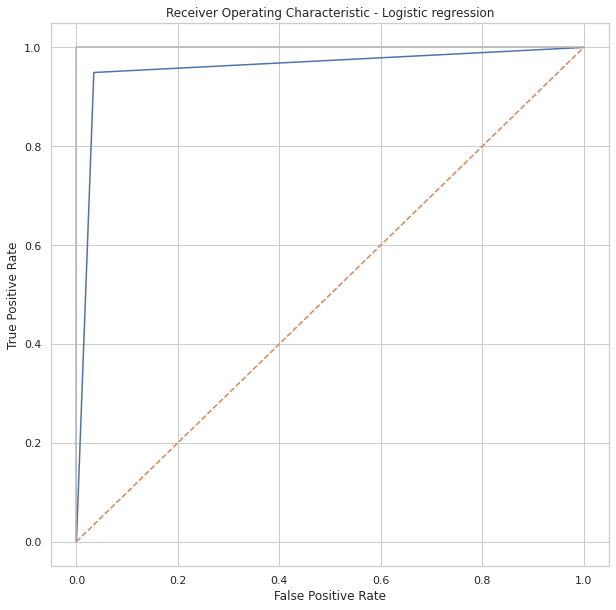

In [57]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_pred))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

F-meausure

In [59]:
f1 = f1_score(y_test, y_pred)
print('F-measure:', f1)

F-measure: 0.9696969696969697


Undersampling

In [ ]:
undersampler = RandomUnderSampler(sampling_strategy='majority')
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Train a logistic regression model
logreg_1 = LogisticRegression(C=0.0001)
logreg_1.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred_2 = logreg_1.predict(X_test)

# Calculate the accuracy score
acc = accuracy_score(y_test, y_pred_2)
print('Accuracy:', acc)

Accuracy: 0.9988879621907145


SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

oversampler = SMOTE(sampling_strategy='minority')
X_train_resampled_1, y_train_resampled_1= oversampler.fit_resample(X_train, y_train)

# Train a logistic regression model
lg = LogisticRegression(C=0.0001)
lg.fit(X_train_resampled_1, y_train_resampled_1)

# Make predictions on the test data
y_pred_3 = lg.predict(X_test)

# Calculate the accuracy score
acc = accuracy_score(y_test, y_pred_3)
print('Accuracy:', acc)

Accuracy: 0.9963858771198221


In [ ]:
confusion_matrix = confusion_matrix(y_test, y_pred_3)
print(confusion_matrix)

[[ 707    0]
 [  13 2877]]
